Must install `imagecodecs` using pip __not__ conda!  (See [this issue](https://github.com/cgohlke/imagecodecs/issues/29))

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from imagecodecs.numcodecs import JpegXl, Jpeg2k, Jpeg
import numcodecs
from numcodecs.registry import register_codec

plt.rcParams["figure.figsize"] = (20, 12)

In [2]:
SRC_SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr" 

In [3]:
satellite_dataset = xr.open_dataset(
    SRC_SATELLITE_ZARR_PATH, 
    engine="zarr", 
    chunks={},  # Load using Dask, using the same chunks as used in the original Zarr dataset.
)

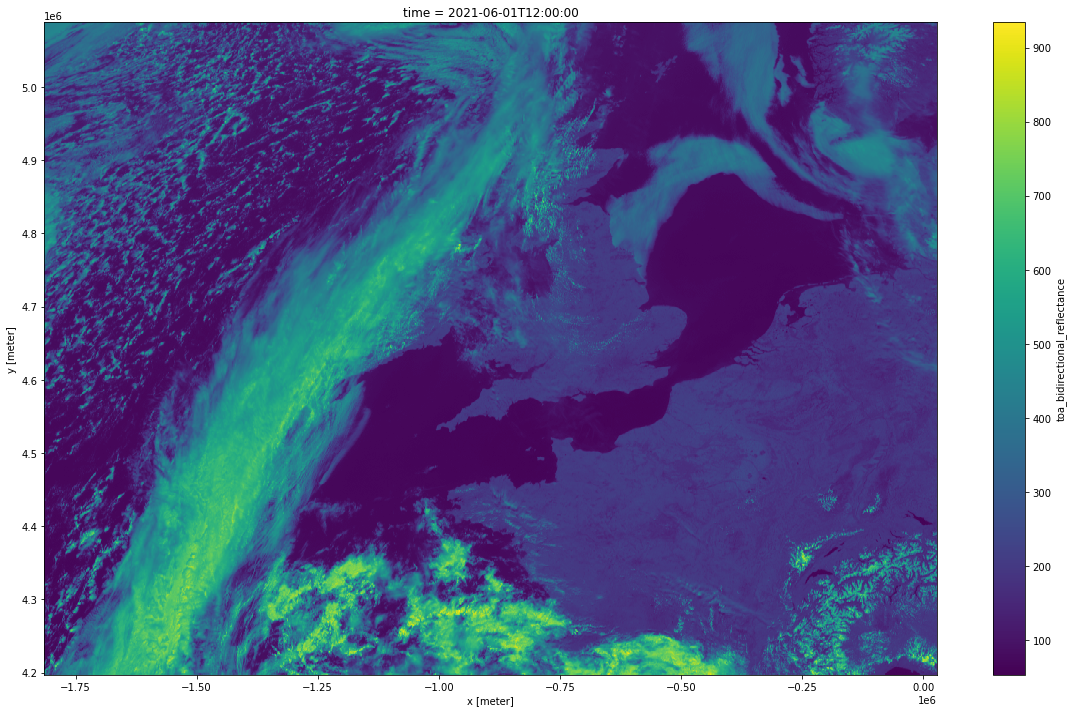

In [4]:
DATETIME_TO_PLOT = "2021-06-01 12:00"
satellite_data_array = satellite_dataset['data']
satellite_data_array.sel(time=DATETIME_TO_PLOT).plot();

```
$cjxl --help

JPEG XL encoder v0.7.0 7613f62 [AVX2,SSE4,SSSE3,Scalar]
Usage: cjxl INPUT OUTPUT [OPTIONS...]
 INPUT
    the input can be PNG, APNG, GIF, JPEG, EXR, PPM, PFM, or PGX
 OUTPUT
    the compressed JXL output file (can be omitted for benchmarking)
 -d maxError, --distance=maxError
    Max. butteraugli distance, lower = higher quality. Range: 0 .. 25.
    0.0 = mathematically lossless. Default for already-lossy input (JPEG/GIF).
    1.0 = visually lossless. Default for other input.
    Recommended range: 0.5 .. 3.0.
 -q QUALITY, --quality=QUALITY
    Quality setting (is remapped to --distance). Range: -inf .. 100.
    100 = mathematically lossless. Default for already-lossy input (JPEG/GIF).
    Positive quality values roughly match libjpeg quality.
 -e EFFORT, --effort=EFFORT
    Encoder effort setting. Range: 1 .. 9.
    Default: 7. Higher number is more effort (slower).
 -p, --progressive
    Enable progressive/responsive decoding.
 --resampling=0|1|2|4|8
    Subsample all color channels by this factor, or use 0 to choose the resampling factor based on distance.
 -v, --verbose
    Verbose output; can be repeated, also applies to help (!).
 -h, --help
    Prints this help message (use -v to see more options).

```

In [6]:
satellite_dataset

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(1, 891, 1843), meta=np.ndarray>

In [19]:
class JpegXlFuture(JpegXl):
    """Simple hack to make the JpegXl compressor in the currently released
    version of imagecodecs (version 2011.11.20) look like the version in development.
    (We can't simply use the version in development because the imagecodecs author
    does not develop on GitHub. The imagecodecs authors just uses GitHub as one of
    several mechanisms to release imagecodecs.)
    
    See https://github.com/cgohlke/imagecodecs/issues/31#issuecomment-1026179413
    """
    
    codec_id = 'imagecodecs_jpegxl'
    
    def __init__(self, lossless=None, decodingspeed=None, level=None, distance=None, *args, **kwargs):
        """
        Args:
            distance: Lowest settings are 0.00 or 0.01.  If 0.0 then also set lossless to True.
            level: DON'T SET THIS WITH THIS JpegXlFuture wrapper! 
                In imagecodecs version 2011.11.20, level is mapped (incorrectly) to the decoding speed tier. 
                Minimum is 0 (highest quality), and maximum is 4 (lowest quality). Default is 0.
            decodingspeed: DON'T SET THIS WITH THIS JpegXlFuture wrapper!
        """
        assert decodingspeed is None
        if lossless is not None:
            if lossless:
                assert level is None  # level must be None to enable lossless in imagecodecs 2011.11.20.
                assert distance is None or distance == 0
            else:
                # Enable lossy compression.
                level = 0  # level must be set to 0, 1, 2, 3, or 4 to enable lossy compression in imagecodecs 2011.11.20.
        super().__init__(level=level, distance=distance, *args, **kwargs)
        
        
register_codec(JpegXlFuture)

In [8]:
#register_codec(Jpeg2k)
#register_codec(Jpeg)

In [166]:
original = satellite_dataset.sel(
    time=[
        "2021-06-01 12:00",
        "2021-06-10 06:00",
        "2021-01-01 09:00",
        "2021-01-01 00:00",
    ]
).clip(max=1023)

In [165]:
original_uint8 = (original / 4).clip(min=0).round().astype(np.uint8)

In [85]:
original_int8_7bpp = (satellite_dataset.sel(
    time=[
        "2021-06-01 12:00",
        "2021-06-10 06:00",
        "2021-01-01 09:00",
        "2021-01-01 00:00",
    ]
).astype(np.float64).clip(max=1023) / 8).round().astype(np.int8)

In [514]:
original_float32 = satellite_dataset.sel(
    time=[
        "2021-06-01 12:00",
        "2021-06-10 06:00",
        "2021-01-01 09:00",
        "2021-01-01 00:00",
    ]
)
original_float32 = original_float32.astype(np.float64)  # Use float64 for maths. Then turn to float32.

# Encode "NaN" as 0.025. Encode all other values in the range [0.075, 1].
# But, after JPEG-XL compression, there is slight "ringing" around the edges.
# So, after compression, use "image < 0.05" to find NaNs.

LOWER_BOUND_FOR_REAL_PIXELS = 0.075
NAN_VALUE = 0.025

In [469]:
original_float32 = original_float32.clip(min=0, max=1023)
original_float32 /= 1023 * (1 + LOWER_BOUND_FOR_REAL_PIXELS)
original_float32 += LOWER_BOUND_FOR_REAL_PIXELS
original_float32 = original_float32.where(
    cond=original >= 0, 
    other=NAN_VALUE,
)
original_float32 = original_float32.astype(np.float32)

In [470]:
original_float32.min().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    data     float32 0.08591

In [471]:
original_float32.max().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    data     float32 0.9243

In [472]:
#original_float32["data"][0, :, :] = 0
original_float32["data"][:, 100:200, 100:200] = 0.025

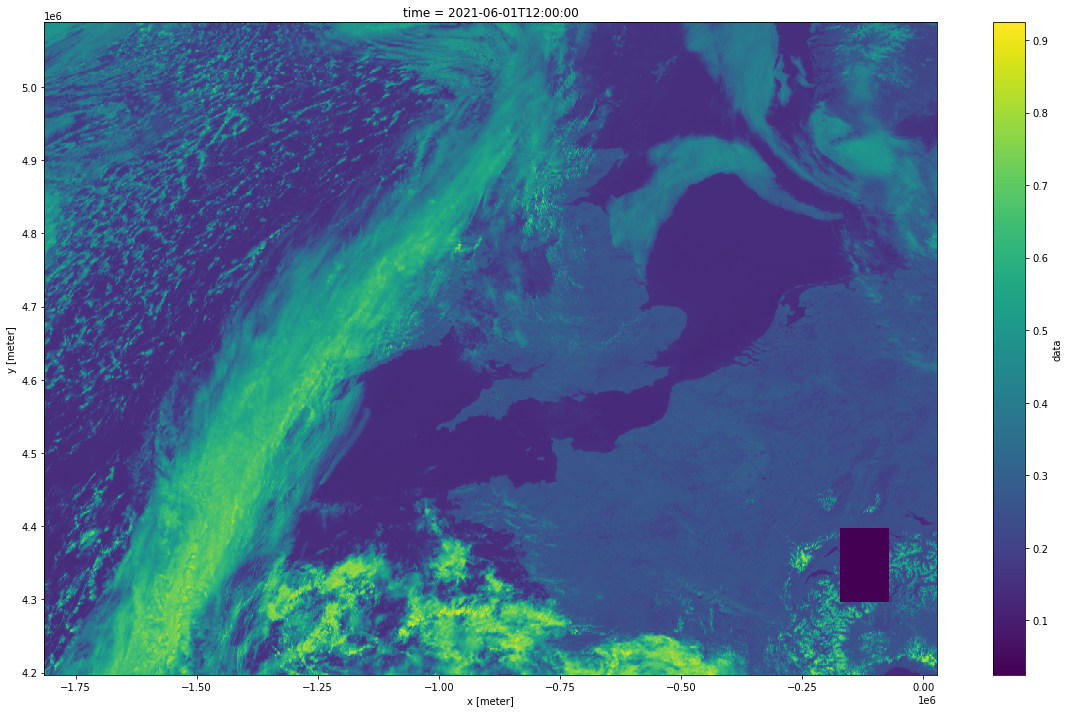

In [473]:
original_float32["data"].isel(time=0).plot();

In [474]:
original_float32["data"].min().compute()

<xarray.DataArray 'data' ()>
array(0.025, dtype=float32)

In [475]:
original_float32["data"].max().compute()

<xarray.DataArray 'data' ()>
array(0.92430323, dtype=float32)

In [476]:
lossless = False
distance = 0.4
effort = 8

OUTPUT_ZARR_PATH = f"gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/jpeg_xl_distance_{distance:.1f}_effort_{effort}_float32_zero_is_NaN_v4.zarr"
#OUTPUT_ZARR_PATH = f"gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/jpeg_2k_level_{level}_float32.zarr"
#OUTPUT_ZARR_PATH = f"gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/bz2_level_5_int8_7bpp_all_positive.zarr"

In [511]:
original_float32.chunks

Frozen({'time': (1, 1, 1, 1), 'y': (891,), 'x': (1843,)})

In [477]:
%%time
encoding = {
    "data": {
        "compressor": JpegXlFuture(lossless=lossless, distance=distance, effort=effort),
        #"compressor": Jpeg2k(level=level),
        #"compressor": numcodecs.get_codec(dict(id="bz2", level=9)),
    },
}

# Need to set to a channel so that JpegXl interprets the first dimension as "time"
#zarr_store = original_uint8.expand_dims(dim="channel", axis=-1).to_zarr(
zarr_store = original_float32.expand_dims(dim="channel", axis=-1).to_zarr(
    OUTPUT_ZARR_PATH,
    mode="w",
    encoding=encoding,
    compute=True,
)

CPU times: user 20.8 s, sys: 607 ms, total: 21.4 s
Wall time: 9.28 s


For four timesteps:

| algo | runtime | size | MAE | PSNR |
|------|---------|-----------|---|----|
| bz2, level=5, int16 | 6.8 sec | 2.9 MB | | |
| jpex-xl, distance=0, effort=7, uint16 | 8.15 sec | 2.2 MB | | |
| jpex-xl, distance=0, effort=9, uint16 | 29 sec | 2.2 MB | 0 | |
| jpex-xl, distance=0, effort=9, float16 | 27.5 sec | 2.2 MB | 0 | 100 |
| jpex-xl, distance=1, effort=7, uint16 | 8.2 sec | 2.2 MB | | |
| jpeg-xl, distance=0.5, effort=9, uint8 | 16.2 s | 0.6 MB | 0.378 | 51.27 |
| jpeg-xl, distance=0.5, effort=8, uint8 | 7.8 s | 0.6 MB | 0.379 | 51.26 |
| jpeg-xl, distance=0.5, effort=7, uint8 | 6.8 s | 0.6 MB | 0.365 | 51.51 |
| jpeg-xl, distance=0.0, effort=7, uint8 | 8.58 s | 1.3 MB | | |
| jpeg-xl, distance=0.0, effort=9, uint8 | 18.2 s | 1.3 MB | | |
| jpeg-xl, distance=1.0, effort=9, uint8 | 12.8 s | 0.4 MB | 0.593 | |
| jpeg-xl, distance=0.1, effort=9, uint8 | 35.6 s | 1.8 MB | | |
| jpeg-xl, distance=0.2, effort=8, uint8 | 10.6 s | 1.2 MB | 0.136 |56.73 |
| jpeg-xl, distance=0.3, effort=8, uint8 | 7.8 s | 0.86 MB | 0.242 | 53.99 |
| jpeg-xl, distance=0.4, effort=8, uint8 | 8.08 s | 0.69 MB | 0.317 | 52.45 |
| jpeg-xl, distance=0.6, effort=8, float16 | 7.8 s | 0.74 MB  | 0.376; or 0.353 after rounding | 52.34 |
| jpeg-xl, distance=0.5, effort=7, float16 | 5.43 s | 0.87 MB | 0.324 | 53.85 |
| jpeg-xl, distance=0.4, effort=8, float16 | 7.8 s | 1.1 MB | 0.2749 | 55.17 |
| jpeg-xl, distance=0.6, effort=8, float32, 0 is NaN | 10.1s | 0.512 MB  |  | 51.58 |
| jpeg-xl, distance=0.6, effort=8, float32, 1 is NaN | 10.5s | 0.733 MB |  | 52.58 |
| jpeg-xl, distance=0.4, effort=8, float32, 0.025 is NaN | 9.8s | 0.698 MB |  | 54.14 |
| jpeg-2k, level=100, uint8 | 4.9 s | 1.1 MB | 0.1625  | 56.01 |
| jpeg-2k, level=80, uint8 | 5.2 s | 1.1 MB | 0.163 | 55.99 |
| jpeg-2k, level=65, uint8 | 5.0 s | 1.0 MB | 0.178 | 55.55 |
| jpeg-2k, level=60, uint8 | 5.0 s | 0.9 MB | 0.210 | 54.78 |
| jpeg-2k, level=55, uint8 | 5.0 s | 0.75 MB | 0.2935 | 53.01 |
| jpeg-2k, level=50, uint8 | 4.9 s | 0.5 MB | 0.468 | 49.79 |
| bz2, level=5, uint8 | 5.64 sec | 1.8 MB | | |
| bz2, level=5, int16 8bpp | 6.55 sec | 1.8 MB | | |
| bz2, level=5, int8 7bpp (with some -1s) | 6.11 sec | 1.3 MB | | |
| bz2, level=5, int8 7bpp (without -1s) | 6.11 sec | 1.3 MB | | |

Some conclusions:

* TL;DR: Let's use jpeg-xl, distance=0.6, effort=8, float16. Need to map values to the range [0, 1], and use `JpegXlFuture` wrapper.
* In the numbers above, JPEG-2000 actually might look a tiny bit better than JPEG-XL! But the imagecodecs implementation of JPEG-2000 doesn't appear to support float16 or float32 (so no representation of NaNs).

In [446]:
310+239+138+2

689

In [380]:
#OUTPUT_ZARR_PATH = f"gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/jpeg_xl_distance_0.6_effort_8_float16.zarr"

In [478]:
opened = xr.open_dataset(
    OUTPUT_ZARR_PATH, engine="zarr", mode="r", 
    backend_kwargs={"storage_options": {"token": "google_default"}})

In [479]:
opened

<xarray.Dataset>
Dimensions:  (time: 4, y: 891, x: 1843, channel: 1)
Coordinates:
  * time     (time) datetime64[ns] 2021-06-01T12:00:00 ... 2021-01-01
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 ...
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 ...
Dimensions without coordinates: channel
Data variables:
    data     (time, y, x, channel) float32 ...

In [480]:
import math

In [548]:
def psnr(img1, img2):
    # Adapted from https://dsp.stackexchange.com/a/50704
    img1 = np.float32(img1).flatten() 
    img2 = np.float32(img2).flatten()
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1023
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [515]:
# Set all values below 0.05 as NaN:
recovered_image = opened.where(opened > 0.05)
recovered_image -= LOWER_BOUND_FOR_REAL_PIXELS
recovered_image *= 1023 * (1 + LOWER_BOUND_FOR_REAL_PIXELS)

In [549]:
psnr(
    recovered_image["data"].fillna(0),
    original["data"].fillna(0),
)


53.74144759051355

In [118]:
psnr(
    (original["data"] / 2).round() * 2,
    original["data"],
)

63.84003007753108

In [520]:
original["data"] = original["data"].astype(np.float32)

In [521]:
original["data"][:, 100:200, 100:200] = np.NaN

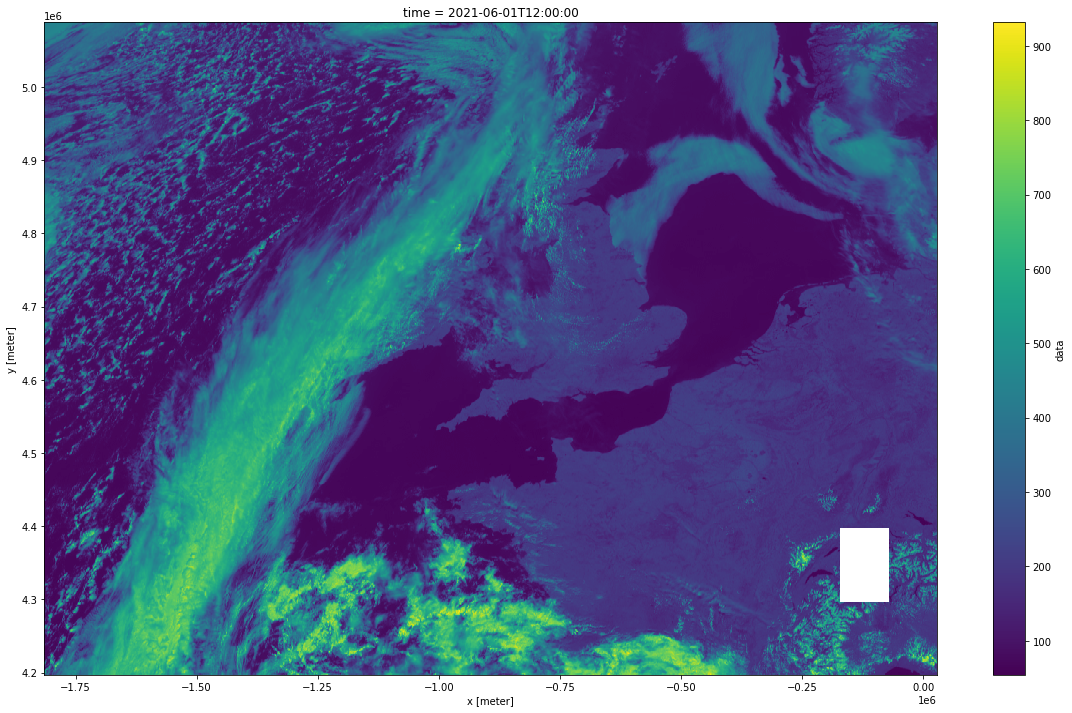

In [518]:
recovered_image["data"].isel(time=0).plot();

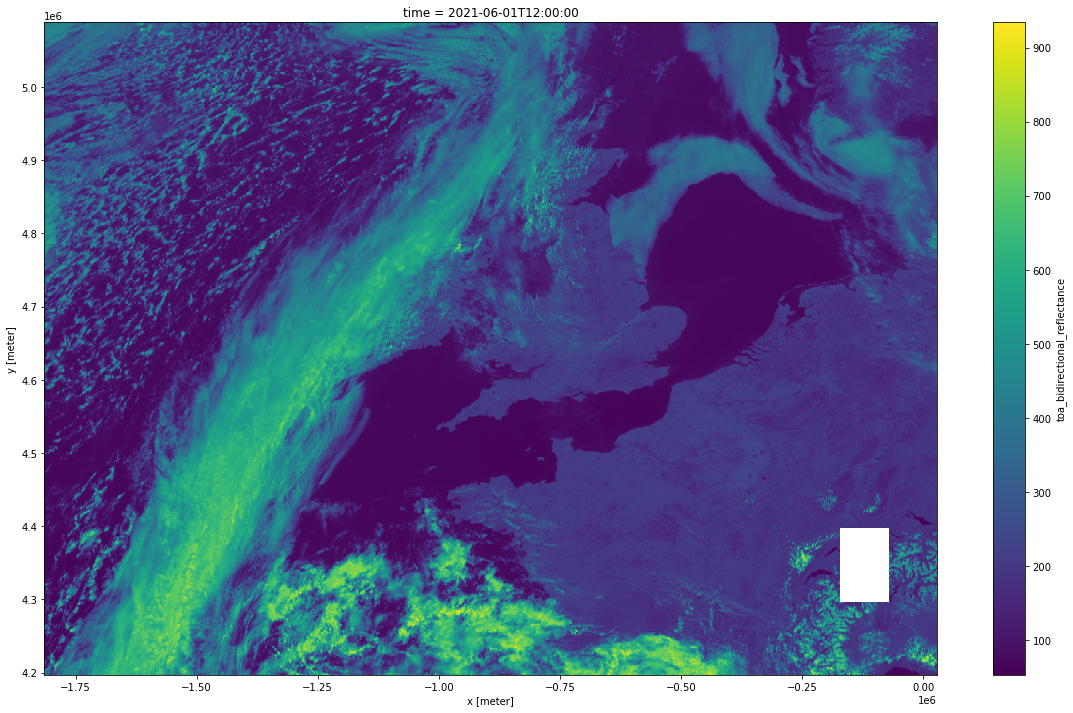

In [522]:
original["data"].isel(time=0).plot();

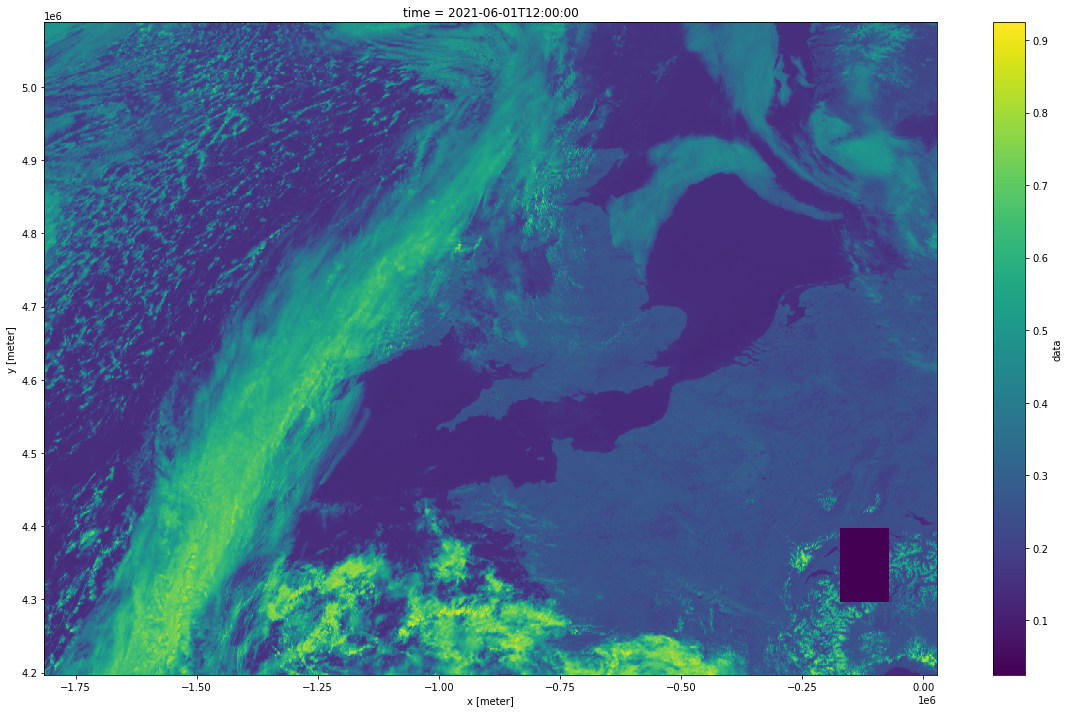

In [483]:
original_float32["data"].isel(time=0).plot();

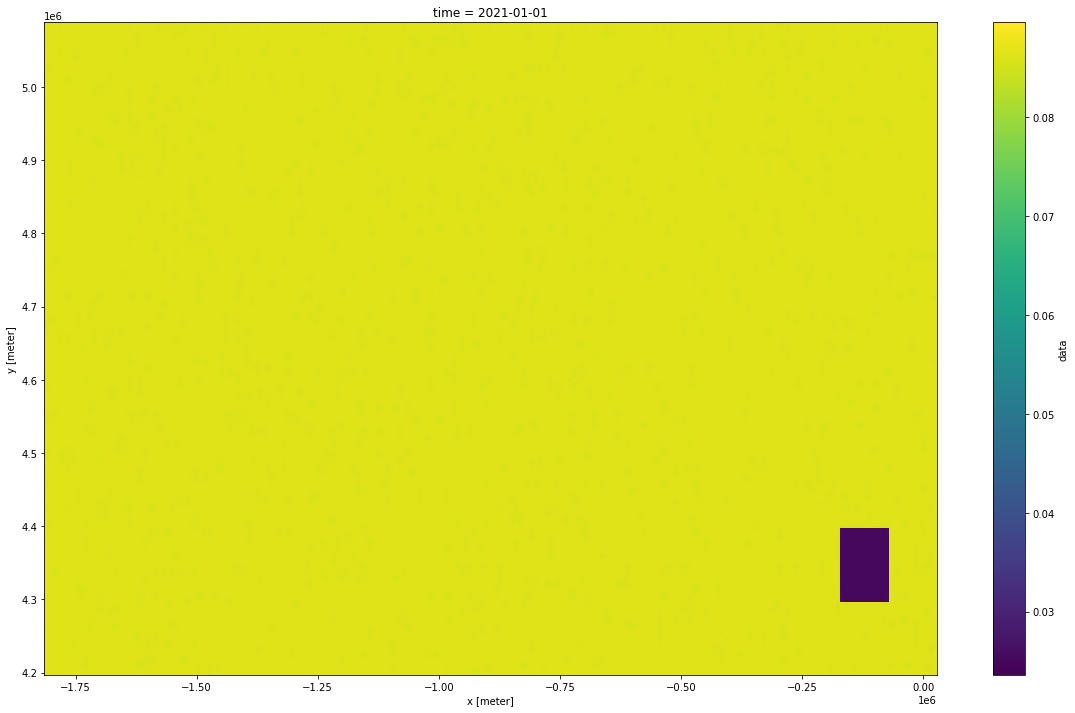

In [487]:
opened["data"].isel(time=3).plot();

In [530]:
recovered_image["data"].min().compute()

<xarray.DataArray 'data' ()>
array(10.182673, dtype=float32)

In [531]:
recovered_image["data"].max().compute()

<xarray.DataArray 'data' ()>
array(931.3931, dtype=float32)

In [532]:
recovered_image["data"][:, 100:200, 100:200].min().compute()

<xarray.DataArray 'data' ()>
array(nan, dtype=float32)

In [533]:
recovered_image["data"][:, 100:200, 100:200].max().compute()

<xarray.DataArray 'data' ()>
array(nan, dtype=float32)

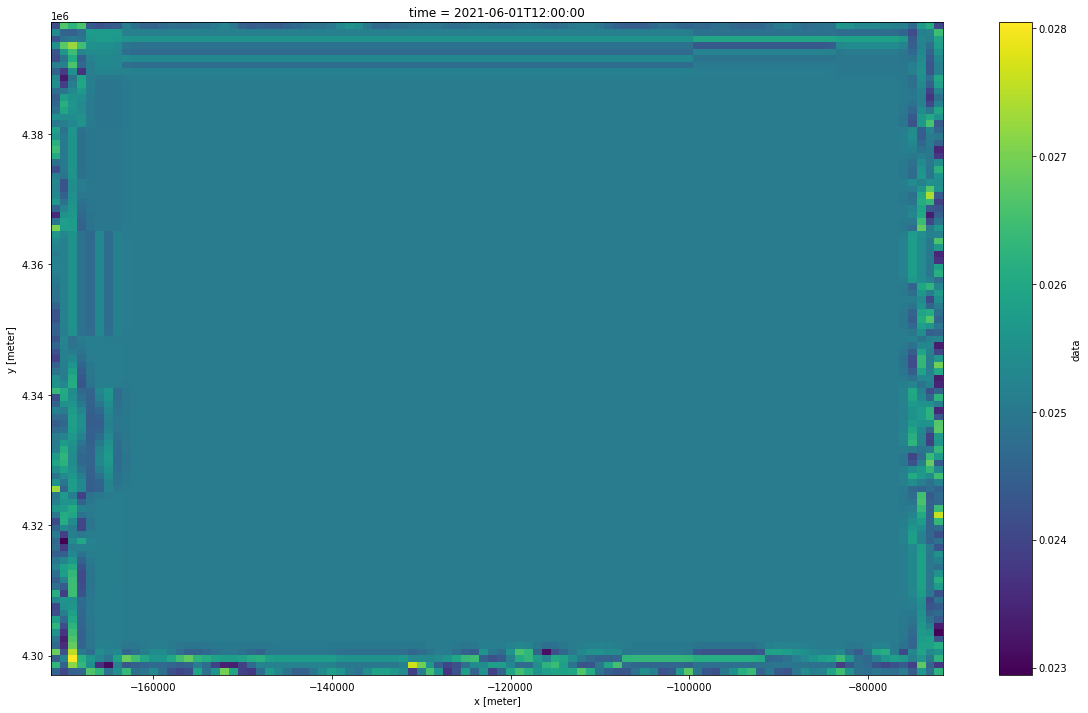

In [510]:
opened["data"][0, 100:200, 100:200].plot();

In [501]:
opened["data"].where(opened["data"] > 0.05).min().compute()

<xarray.DataArray 'data' ()>
array(0.08425929, dtype=float32)

In [502]:
opened["data"].where(opened["data"] > 0.05).max().compute()

<xarray.DataArray 'data' ()>
array(0.92193276, dtype=float32)

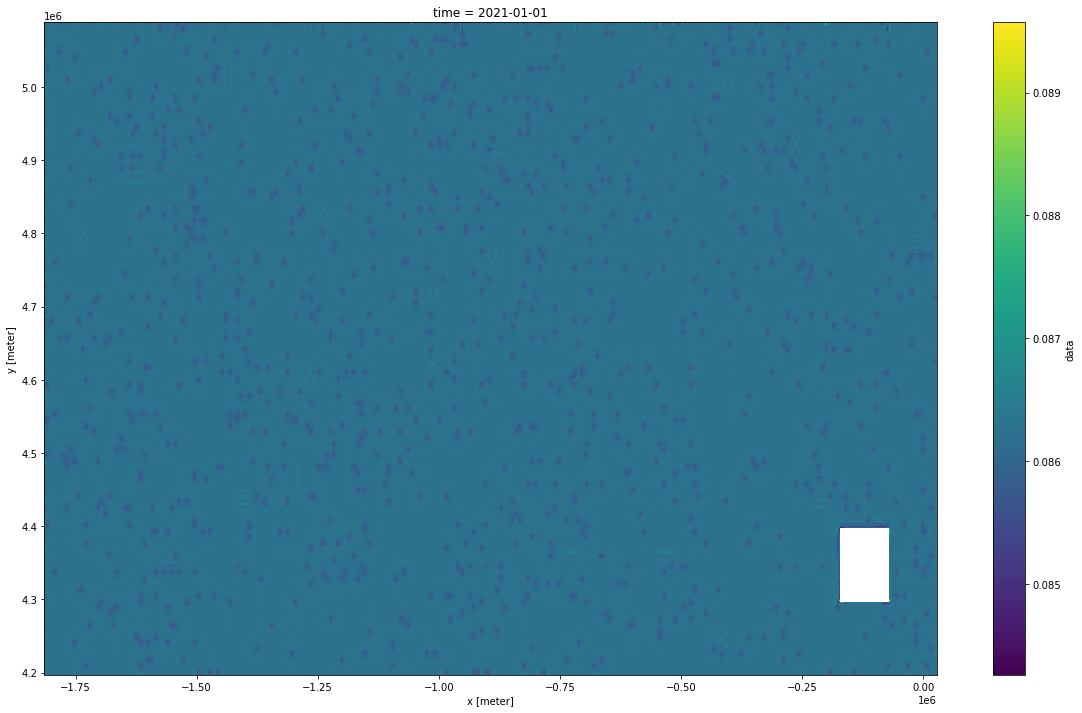

In [506]:
opened["data"].where(opened["data"] > 0.05)[3].plot();

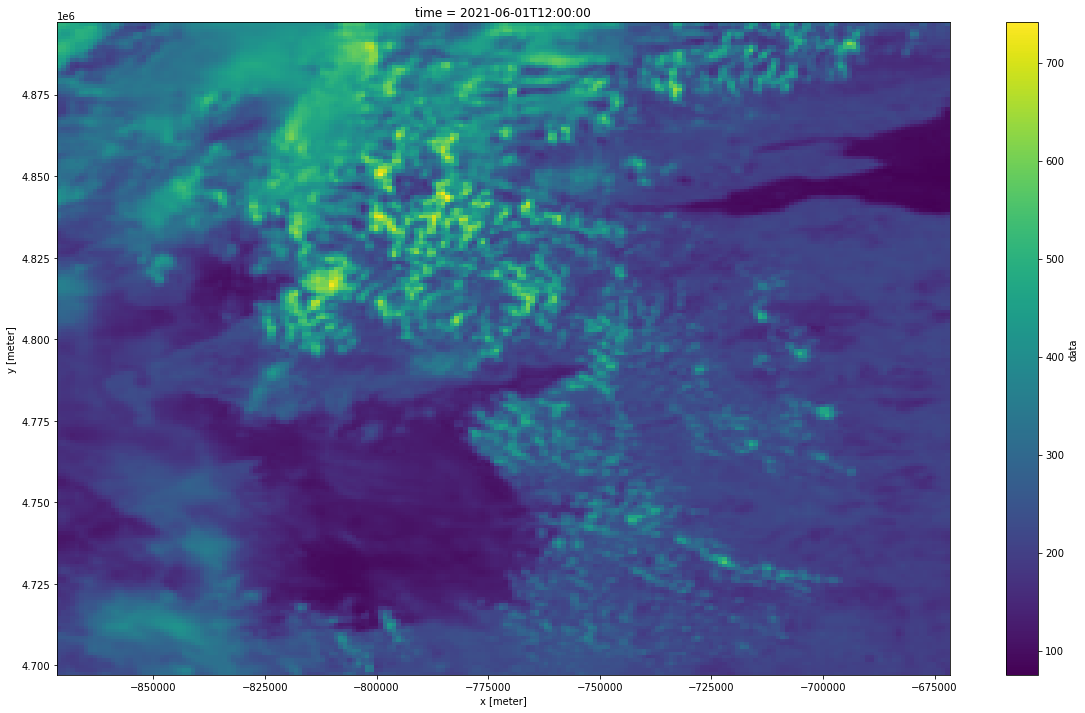

In [534]:
(recovered_image["data"].isel(time=0, x=slice(700, 900), y=slice(500, 700))).plot();

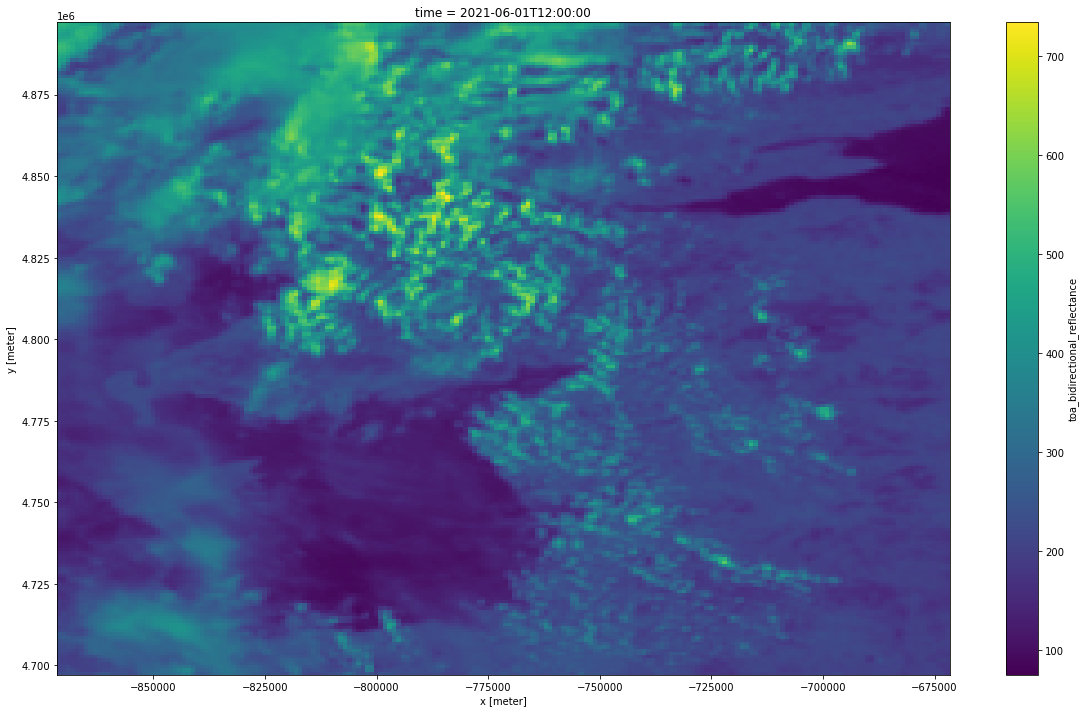

In [535]:
original["data"].sel(time=DATETIME_TO_PLOT).isel(x=slice(700, 900), y=slice(500, 700)).plot();

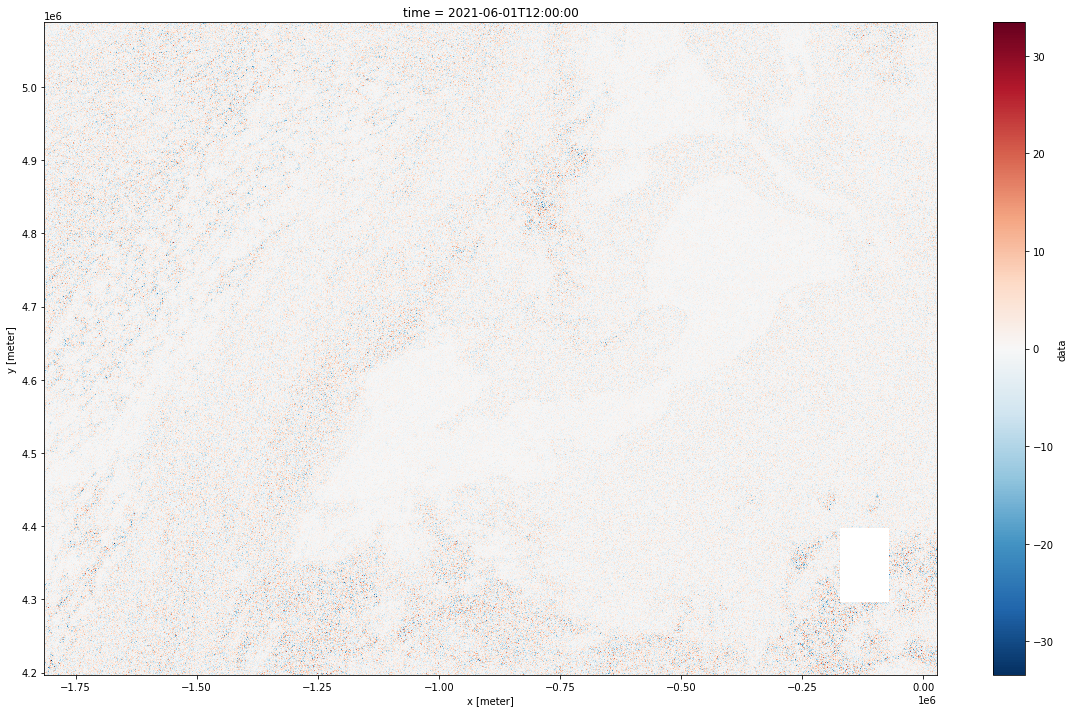

In [536]:
diff = ((recovered_image["data"].astype(np.float32)) - (original["data"].astype(np.float32)))
diff.isel(time=0).plot();

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [537]:
np.abs(diff).mean().compute().values

array(1.392278, dtype=float32)

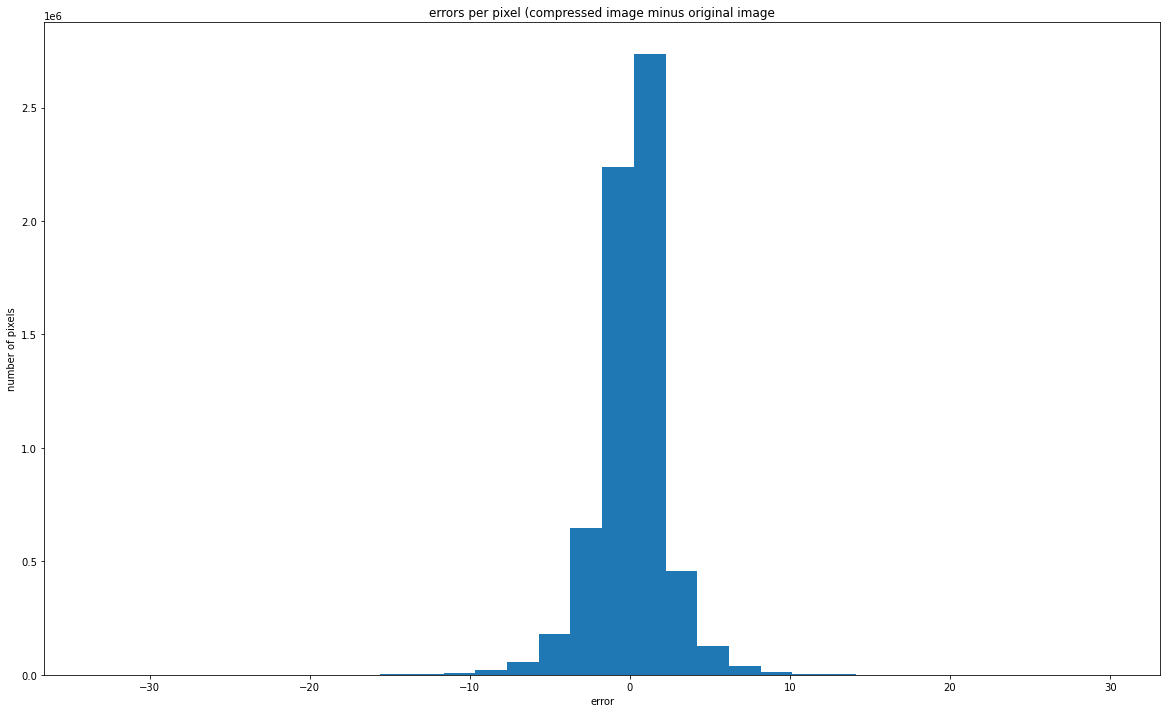

In [539]:
ax = plt.axes()
ax.hist(diff.values.flatten(), bins=32) #np.arange(-0.02, 0.021, 0.001))
ax.set_title("errors per pixel (compressed image minus original image")
ax.set_ylabel("number of pixels")
ax.set_xlabel("error");

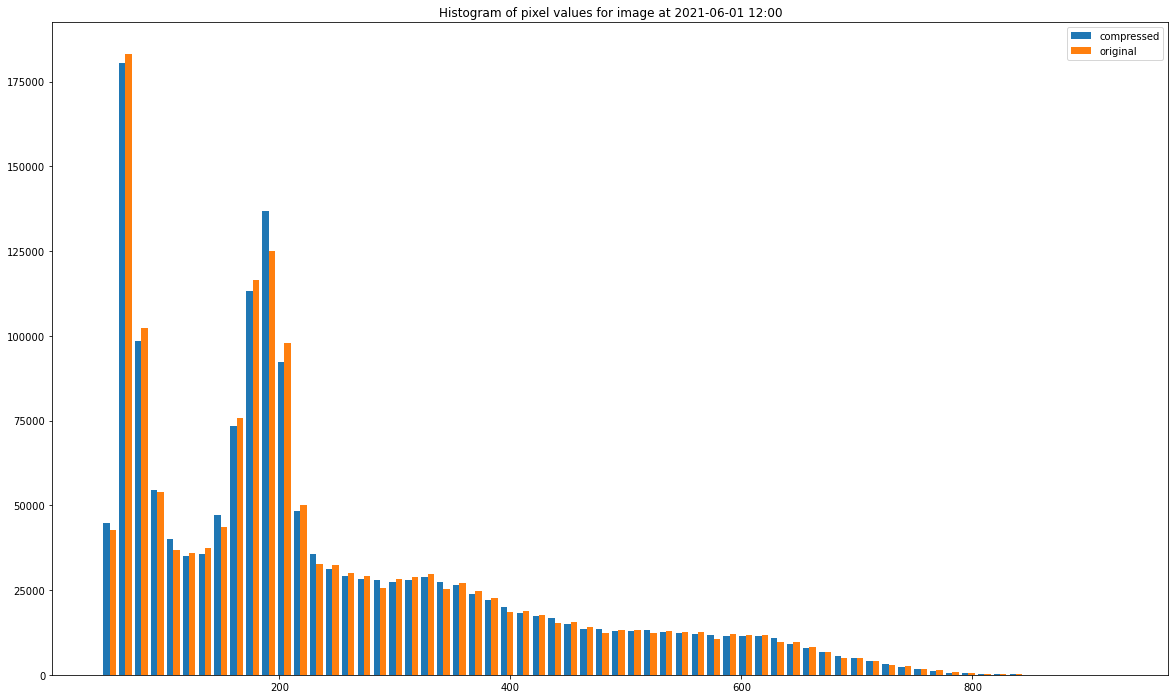

In [541]:
TIME_I = 0
ax = plt.axes()
ax.hist(
    (
        recovered_image["data"].isel(time=TIME_I).values.flatten(),
        original["data"].isel(time=TIME_I).values.flatten(),
    ),
    bins=64,
    align='left',
    label=["compressed", "original"]
);
ax.legend()
ax.set_title("Histogram of pixel values for image at " + pd.Timestamp(opened["data"].isel(time=TIME_I).time.values).strftime("%Y-%m-%d %H:%M"));

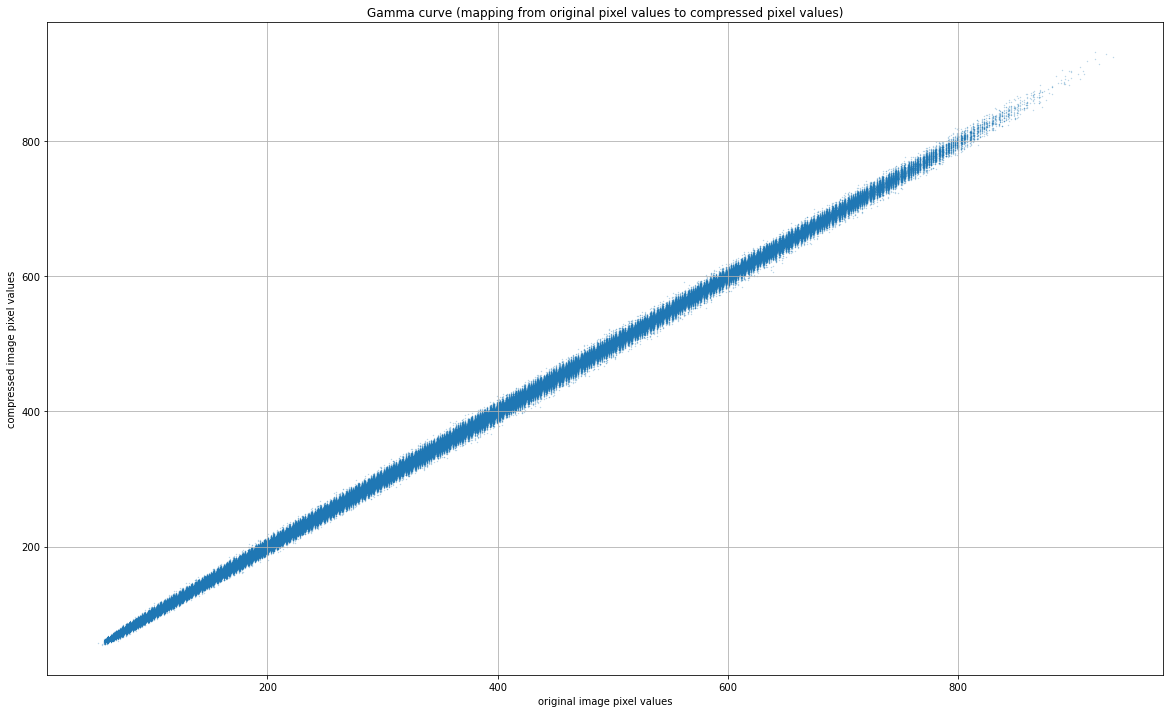

In [542]:
ax = plt.axes()
TIME_I = 0
ax.scatter(
    x=original["data"].isel(time=TIME_I).values.flatten(),
    y=recovered_image["data"].isel(time=TIME_I).values.flatten(),
    alpha=0.3,
    linewidth=0,
    s=2,
);
ax.grid(visible=True)
ax.set_title("Gamma curve (mapping from original pixel values to compressed pixel values)")
ax.set_xlabel("original image pixel values")
ax.set_ylabel("compressed image pixel values");